# The Response of Sea Surface Temperature to Rain
Ongoing summary of research/analysis to serve as the skeleton for the eventual publication.



# Body of Analysis

In [6]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as datetime
import glob
import scipy
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from scipy.signal import find_peaks

## Section 1: Dynamo

### Rain Detection

Import data from R/V Revelle meteorological sensors, including precipitation:

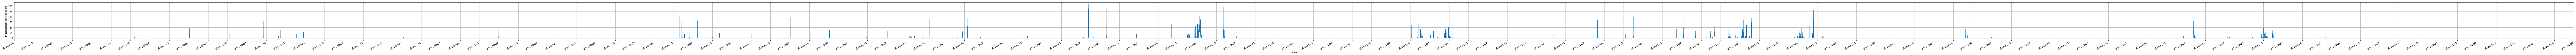

In [2]:
#import rain data
revelle_datapath = '..\Data\Level_3\Dynamo\Revelle_FluxData\Revelle_All_Legs.cdf'
rv = xr.open_dataset(revelle_datapath)
plt.subplots(figsize=(200,3),facecolor='w')
rv.P.plot()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))   #to get a tick every day minutes
plt.grid()

Slice every separate rain event out first (defined as being at least *'min_duration'* long, with a peak rainfall rate of at least *'threshold'*, and surrounded by at least *'min_separation'* minutes of zero precipitation). Then examine the plots of all rain events to tune parameters and identify any that should be removed...

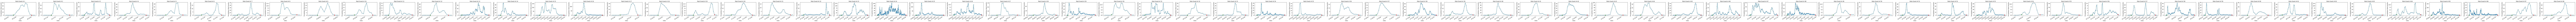

In [3]:
from RainEvent_Toolbox import find_rain_events
rain_event_list = find_rain_events(dataset = rv, 
                                   min_duration = 10,
                                   min_separation = 10,
                                   threshold = 10,
                                   noise_floor = 0.5,
                                   front_pad = 5, 
                                   end_pad = 3)
plt.savefig('./Figures/Dynamo Rain Event Detection v2.png')

Now slice out SST data for each event and calculate relevant parameters:

In [5]:
#import SST data
kt_dynamo = xr.open_dataset('../Data/Level_3/Dynamo/KT15/Dynamo_KT15_CalibratedSST.cdf')
#resample SST to 10 seconds
kt_1m = kt_dynamo.sortby(kt_dynamo.index).SST.resample(index='10s').mean()
#how many minutes before rain onset do we want to average as the baseline from which to calculate a delta?
pre_onset_averaging = 3

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


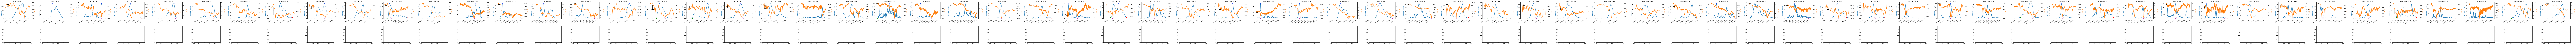

In [6]:
from RainEvent_Toolbox import sst_rain_response
sst_event_list = sst_rain_response(rain_event_list = rain_event_list,
                                   sst = kt_1m,
                                   pre_onset_averaging = pre_onset_averaging)
plt.savefig('./Figures/Dynamo Rain Events + SST + Fluxes v2.png')

Plot rain rate, $\delta$SST, rain heat flux, and wind speed on standardized y-axis scales for all events:

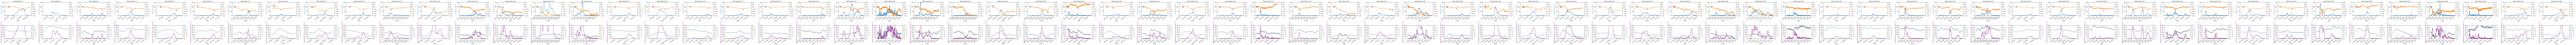

In [7]:
from RainEvent_Toolbox import plot_rain_events
plot_rain_events(rain_event_list = rain_event_list,  
                 sst_event_list = sst_event_list, 
                 rain_ylims = [-1,150],
                 δsst_ylims = [-1,0.5],
                 rhf_ylims = [0,300],
                 wind_ylims = [0,15])
plt.savefig('./Figures/Dynamo Rain Events + deltaSST + Wind v2.png')

### Comparing Event Characteristics

Plot histograms:

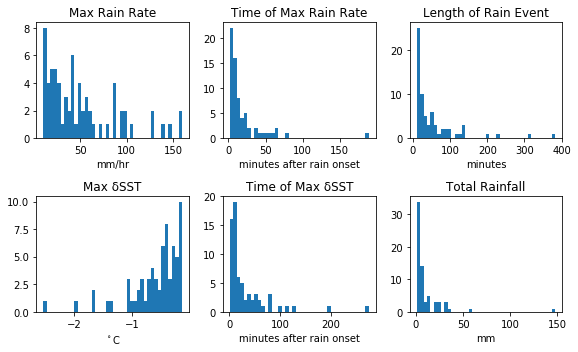

In [7]:
from RainEvent_Toolbox import extract_event_characteristics, plot_histograms
rain_events_summary = extract_event_characteristics(rain_event_list, sst_event_list)
plot_histograms(rain_events_summary, nbins=40)
plt.savefig('./Figures/Histograms v2.png')

Plot relationships between variables:

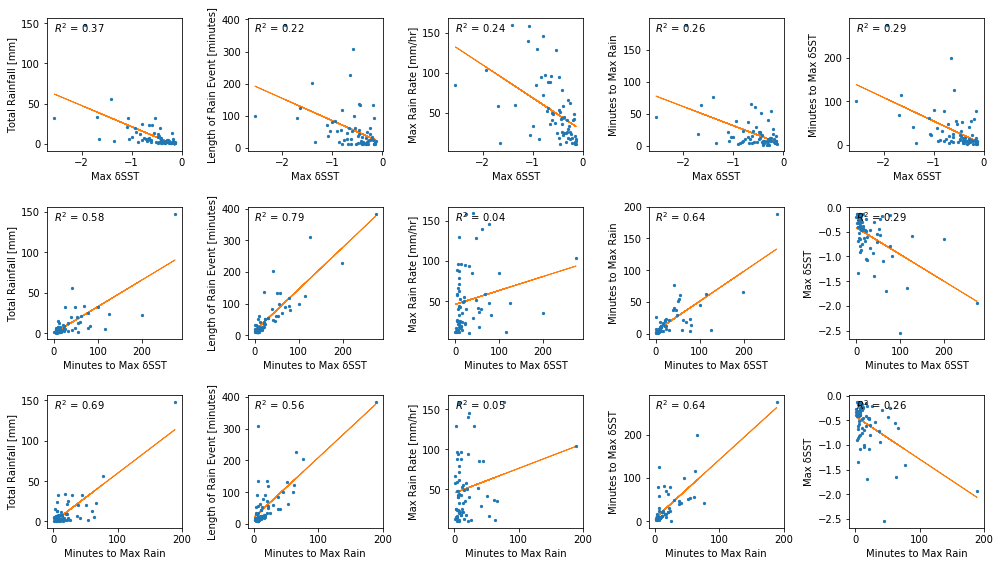

In [8]:
from RainEvent_Toolbox import plot_relationships
plot_relationships(rain_events_summary)
plt.savefig('./Figures/Scatterplots v2.png')

The three highest correlations are between:
- Minutes to Max $\delta$SST vs. Length of Rain Event ($R^2$ = 0.79)
- Minutes to Max Rain vs. Total Rainfall ($R^2$ = 0.69)
- Minutes to Max Rain vs. Minutes to Max $\delta$SST ($R^2$ = 0.64)

- Should we use a criteria like "95% of total rainfall equally distributed around the peak rain rate" to classify more relevant start and end times for the events? Maybe, but it adds a layer of abstraction
- Try "average rain rate" (total rainfall/length of rain event) - add to the scatter plots
- could then compare that to max rain rate to see how much of the event is "low"/long tails

### Composite Rain Event

First we want to calculate the deltas for any variables we might be interested in from the rain events ($\delta$SST was already calculated):

In [9]:
#define the relevant paramters you would like to calculate a delta for (in addition to SST)
param_list = ['Tsea','TseaTSG','SalTSG','T02','T10','U10']

In [10]:
from RainEvent_Toolbox import calculate_deltas
rain_event_list = calculate_deltas(rain_event_list = rain_event_list,
                                   param_list = param_list,
                                   pre_onset_averaging = pre_onset_averaging)

Now we're ready to put together a composite plot of these delta variables for all rain events. The key is to normalize the timescale by the time to peak SST response, i.e. 
$$ Normalized Time = \frac{(CurrentMinute - StartMinute)}{(Minutes to Max \delta SST)} $$

This way, the rain start is at zero and the peak SST response is at 1. This allows us to superimpose all the rain events in a meaningful way. I've also scaled the size of the dots to indicate what proportion of events were involved in each bin (all events are included between timesteps 0 and 1, of course).

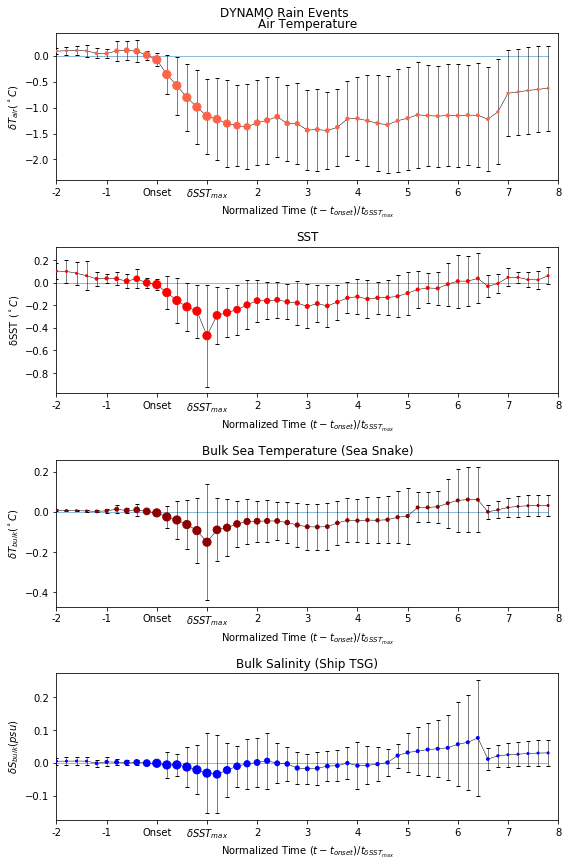

In [14]:
from RainEvent_Toolbox import extract_composite_event
composite_event = extract_composite_event(rain_event_list = rain_event_list, 
                                          sst_event_list = sst_event_list, 
                                          param_list = param_list, 
                                          start = -2, 
                                          stop = 8, 
                                          spacing = 0.2)
plt.savefig('./Figures/Composite Events v1.png')

The one thing that is clearly missing from this is a plot of the actual rain rates on this normalized timescale!!

## Section 2: Process Study from Falkor Rain Events

There were 4 rain events over the two Falkor cruises that meet the criteria established in the Dynamo rain processing. 2 from 2016, and 2 events from 2019. We have more different types of observations of these events, but they also need to be pieced together.

### Rain Event Detection from Catamaran Rain Sensor

#### Falkor 2016:

Import data from catamaran, including precipitation:

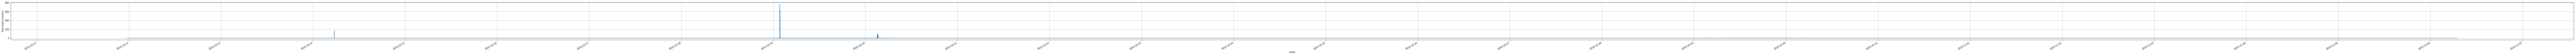

In [75]:
#import rain data
cat_datapath = '../Data/Level_3/Falkor16/Catamaran/catamaran_fk16_alldata.cdf'

cat = xr.open_dataset(cat_datapath)
plt.subplots(figsize=(200,3),facecolor='w')
cat.P.plot()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))   #to get a tick every day minutes
plt.grid()

Slice every separate rain event out first (defined as being at least *'min_duration'* long, with a peak rainfall rate of at least *'threshold'*, and surrounded by at least *'min_separation'* minutes of zero precipitation). Then examine the plots of all rain events to tune parameters and identify any that should be removed...

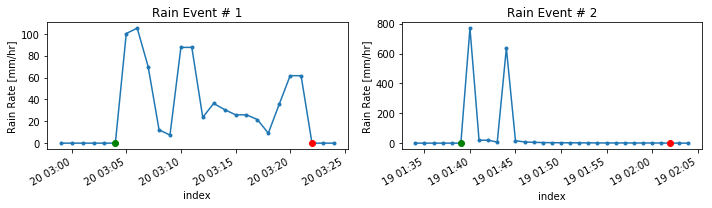

In [76]:
from RainEvent_Toolbox import find_rain_events
rain_event_list = find_rain_events(dataset = cat, 
                                   min_duration = 10,
                                   min_separation = 10,
                                   threshold = 10,
                                   noise_floor = 0.5,
                                   front_pad = 5, 
                                   end_pad = 3)
plt.savefig('./Figures/Falkor 2016 Rain Event Detection v1.png')

Now slice out SST data for each event and calculate relevant parameters:

In [11]:
#import SST data
kt_falkor16 = xr.open_dataset('../Data/Level_3/Falkor16/KT15/Falkor16_KT15_CalibratedSST.cdf').rename(DateTime='index')
#resample SST to 10 seconds
kt_1m = kt_falkor16.sortby(kt_falkor16.index).SST.resample(index='10s').mean()
#how many minutes before rain onset do we want to average as the baseline from which to calculate a delta?
pre_onset_averaging = 3

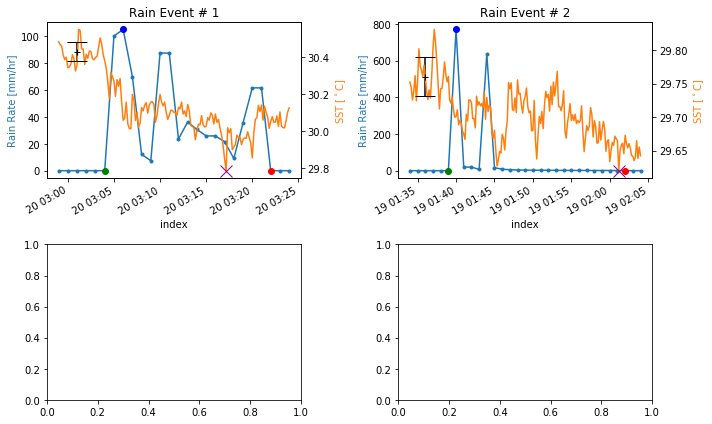

In [12]:
from RainEvent_Toolbox import sst_rain_response
sst_event_list = sst_rain_response(rain_event_list = rain_event_list,
                                   sst = kt_1m,
                                   pre_onset_averaging = pre_onset_averaging)
plt.savefig('./Figures/Falkor 2016 Rain Events + SST.png')

So there are 2 rain events from Falkor 2016 that fit the parameters established for the Dynamo dataset. These could be used as part of the process study side of things. We do have both imagery types for the October 20th event, but only Mitie for the October 19 (the polarimetry failed to record during that specific 20 minutes of rainfall). The October 20th event is the one from the 2018 JGR paper. 

#### Falkor 2019

Things get a little bit funky with this one because there are multiple data entries for individual timestamps. I haven't been able to figure out how to get rid of that (resampling is behaving very strangely, yielding all nans) so I'm just doing it manually here.

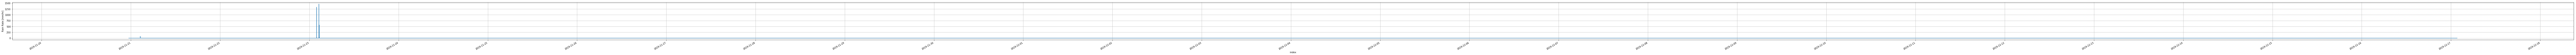

In [8]:
#import rain data
cat_datapath19 = '../Data/Level_3/Falkor19/Catamaran/catamaran_fk19_alldata.cdf'

cat19 = xr.open_dataset(cat_datapath19)#.resample(index='1s').mean()
plt.subplots(figsize=(200,3),facecolor='w')
cat19.P.plot()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))   #to get a tick every day
plt.grid()

Slice every separate rain event out first (defined as being at least *'min_duration'* long, with a peak rainfall rate of at least *'threshold'*, and surrounded by at least *'min_separation'* minutes of zero precipitation). Then examine the plots of all rain events to tune parameters and identify any that should be removed...

In [9]:
dataset = cat19
min_duration = 10
min_separation = 10
threshold = 10
noise_floor = 0.5
front_pad = 5
end_pad = 3

rain_rate = dataset.P
rain_event_list = []
rain_event_counter = 0
timestep = 0
while timestep < len(rain_rate):
    #if the current rain rate isn't zero:
    if (rain_rate.isel(index=timestep).values > noise_floor):
        #then we've got ourselves the start of a rain event!
        rain_start = timestep-1 #preceding zero value is the start, for consistency with Deb's approach
        raining = True
        #enter a new loop that finds the end index of this rain event
        while raining:
            #if the current rain rate is zero...AND...it's going to be zero from now until 'min_separation' from now:
            if (rain_rate.isel(index=timestep).values <= noise_floor and
                np.mean(rain_rate.isel(index=slice(timestep,timestep+min_separation)).values) <= noise_floor):
                    #then we've located the end of the rain event
                    rain_end = timestep
                    raining = False
                    #create new dataarray containing solely this rain event, plus some extra timesteps on either side
                    rainevent = dataset.isel(index=slice(rain_start-front_pad,rain_end+end_pad))
                    #calculate peak rainfall rate - if you encounter any issues, set the rate to zero
                    try:
                        peak_rate = dataset.isel(index=slice(rain_start,rain_end)).P.max().values.item()
                    except ValueError:
                        peak_rate = 0
                    #check if the peak of the rain event exceeds 'threshold' and the rain event is long enough
                    if (peak_rate >= threshold and (rain_end - rain_start) >= min_duration):
                        #if so, fill out metadata and add this to the master list of rain events
                        rain_event_counter = rain_event_counter + 1
                        rainevent.attrs['Rain Event #'] = rain_event_counter
                        rainevent.attrs['Rain Onset'] = rain_rate.isel(index=rain_start).index.values
                        rainevent.attrs['Rain End'] = rain_rate.isel(index=rain_end).index.values
                        rainevent.attrs['Peak Rate'] = peak_rate
                        rainevent.attrs['Peak Time'] = rainevent.P.where(rainevent.P==peak_rate,drop=True).index.values[0]
                        rain_event_list.append(rainevent)
                        #(if not, just discard and move on)
            #as long as it keeps raining, just increment the timestep and start over
            else:
                timestep = timestep + 1
        #[spits us out at the timestep after the event ends]
    #if we haven't found a rain event, just increment the timestep and start over
    else:
        timestep = timestep + 1
len(rain_event_list)


3

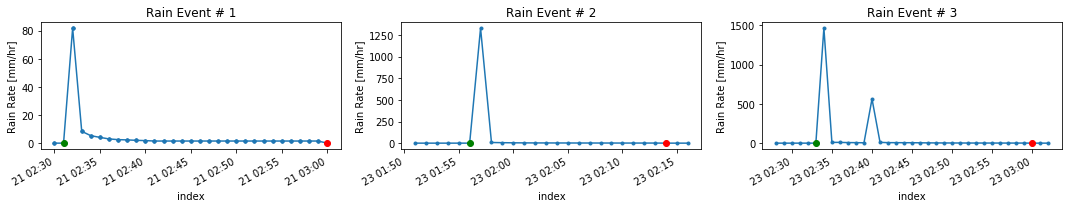

In [10]:
figlength = 5*len(rain_event_list)
fig, axx = plt.subplots(nrows=1, ncols=len(rain_event_list),facecolor='w',figsize=(figlength,3))

for event_num in np.arange(0,len(rain_event_list)):
    rain_event_list[event_num].P.plot.line('-o',ax=axx[event_num],markersize=3,fillstyle=None)
    axx[event_num].set_title(f'Rain Event # {event_num+1}')
    start = rain_event_list[event_num].attrs['Rain Onset']
    axx[event_num].plot(start,rain_event_list[event_num].P.sel(index=start).mean(),'.g',markersize=12,fillstyle=None)
    end = rain_event_list[event_num].attrs['Rain End']
    axx[event_num].plot(end,rain_event_list[event_num].P.sel(index=end).mean(),'.r',markersize=12,fillstyle=None)
plt.tight_layout()
plt.savefig('./Figures/Falkor 2019 Rain Event Detection v2.png')

Now slice out SST data for each event and calculate relevant parameters:

In [13]:
#import SST data
kt_falkor19 = xr.open_dataset('../Data/Level_3/Falkor19/KT15/Falkor19_KT15_CalibratedSST_v2.cdf').rename(DateTime='index')
#resample SST to 10 seconds
kt_1m = kt_falkor19.sortby(kt_falkor19.index).SST.resample(index='10s').mean()
#how many minutes before rain onset do we want to average as the baseline from which to calculate a delta?
pre_onset_averaging = 3

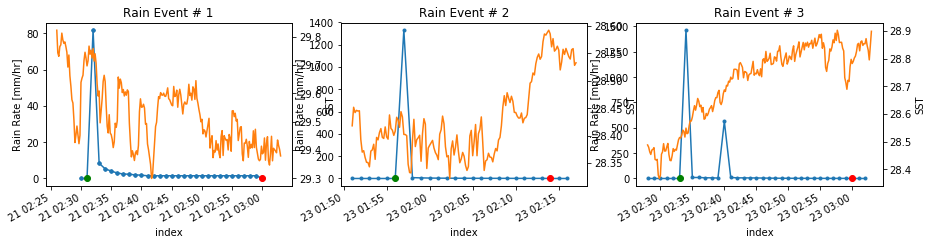

In [14]:
#from RainEvent_Toolbox import sst_rain_response
#sst_event_list = sst_rain_response(rain_event_list = rain_event_list,
#                                   sst = kt_1m,
#                                   pre_onset_averaging = pre_onset_averaging)

figlength = 5*len(rain_event_list)
fig, axx = plt.subplots(nrows=1, ncols=len(rain_event_list),facecolor='w',figsize=(figlength,3))


for event_num in np.arange(0,len(rain_event_list)):
    rain_event_list[event_num].P.plot.line('-o',ax=axx[event_num],markersize=3,fillstyle=None)
    axx[event_num].set_title(f'Rain Event # {event_num+1}')
    start = rain_event_list[event_num].attrs['Rain Onset']
    axx[event_num].plot(start,rain_event_list[event_num].P.sel(index=start).mean(),'.g',markersize=12,fillstyle=None)
    end = rain_event_list[event_num].attrs['Rain End']
    axx[event_num].plot(end,rain_event_list[event_num].P.sel(index=end).mean(),'.r',markersize=12,fillstyle=None)
    #axx[event_num].set_xlim([start,end])
    
    ax2 = axx[event_num].twinx()
    kt_1m.sel(index=slice(start-pd.Timedelta('5min'),end+pd.Timedelta('3min'))).plot(ax=ax2,color='C1')
    

plt.savefig('./Figures/Falkor 2019 Rain Events + SST v2.png')

Coverage notes:

- SPIP was in the water to witness both of these events. The 21st corresponds to SPIP deployment 2, while the 23rd corresponds to SPIP deployment 4.
- The 21st has mitie coverage from 2:27 - 2:47am, perfect for that rain event. The 23rd has Mitie coverage from 1:50-2:10 (perfect for rain event 2) and 2:50-3:10 (less useful for rain event 3)

There was also another rain event observed by SPIP on the 22nd after the catamaran was pulled, where a freshwater lens formed !! . Here is the SPIP plot, and a plot of the SST:

![Dep2RainSPIP](./Figures/SPIP_SummaryPlot_deployment2_RainEvent.png)

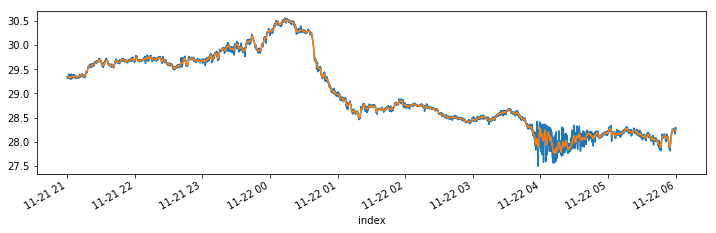

In [29]:
plt.figure(figsize=(12,3),facecolor='w')
kt_1m.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].plot()
kt_1m.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].rolling(index=10,center=True).mean().plot()

Timeline of events _At SPIP's location_: 
1. Winds pick up around 00:30, destroying the DWL and likely leading to the sudden decrease in SST measured by the KT-15s. 
2. Light rain begins around 01:15, and SPIP observes a cold surface layer (likely due to the heat flux associated with the wind increase). 
3. **Mitie was recording from 03:27-03:47**. Then from 03:45-04:00, the rain rate increases greatly and a cold freshwater lens develops in the upper ~1.5m. We see that reflected in the KT15 data as well, a significant drop in the same time period. 
4. Unfortunately SPIP was pulled shortly after 4:00, but the KT15 data does suggest that the rain event continued for less than an hour. Perhaps we could use ship met data to corroborate the story of the storm passing. The Mitie makes observations again from 04:27-04:47, so that could also give us insight into the tail end of the event. 

# NEXT STEPS
Characterize the 4-6 Falkor rain events:
- Where do they fall in the Dynamo composite event plots? - plot on top
- Compile all the different data from each event and put into nice readable plots
- Make a simple outline for the paper

# Appendices

## Appendix 0: Review of datasets

## Dynamo 
### Variable Names

$\Delta SST_{skin}$ - departure of skin temperature (KT15) from 3-minute mean prior to rain onset

$t_{*SST}$ - time from rain onset to maximum SST response (maximum $\Delta SST_{skin}$)

$L_{rain}$ - length of rain event

$t_{*rain}$ - time from rain onset to peak rain rate

### Overview of DYNAMO dataset

The figure below shows a series of histograms of relevant variables for each of the 103 identified rain events on DYNAMO.
The events are largely ~1hr long and deposit ~15mm rain, with only a few very long events (>10hrs). The mean $\Delta SST_{skin}$ due to rain is $-0.51 ^\circ C$.

![Histograms](./Figures/Histograms v1.png)


### Relationships between variables

The figure below attempts to relate both the maximum skin temperature deviation ($\Delta SST_{skin}$) and the time between rain onset and maxiumum skin temperature deviation ($t_{*SST}$) to other relevant parameters.
![Scatterplots](./Figures/Scatterplots v1.png)

The relationship between $t_{*rain}$ and $t_{*SST}$ looks fairly robust and close to 1:1 (red line). It makes some intuitive sense that the time period of the largest rain rate would tend to correspond to the time period of the largest SST deviation.

The other relationship that may have some legs is between $L_{rain}$ vs. $t_{*SST}$. However, this correspondence may just reflect the agreement between $t_{*rain}$ and $t_{*SST}$, in that longer rain events may tend to take longer to reach their maximum rain rate. **Plot $L_{rain}$ vs. $t_{*rain}$ and verify.** 

### Normalized timeseries of temperature deviation

The figure below shows a bin-averaged timeseries of all 103 rain events, where rain onset for each event corresponds to T=0, and the timescale of the event is normalized by $t_{*SST}$, the time it takes to reach the maximum SST deviation. This means that the maximum $\Delta SST_{skin}$ always occurs at T=1. 

![Timeseries](./Figures/Timeseries_v1.png)

It would seem to make more sense to **normalize the timescale in this figure by $t_{*rain}$ rather than $t_{*SST}$**, especially given the good correspondence between the two.

The **locations of the bins** also seem arbitrary and poorly chosen, as there is no bin centered on 0 or 1, the two most important parts of the timescale. 

There is very close temporal alignment of the trends in $\Delta SST_{skin}$, $\Delta T_{bulk}$, and $\Delta T_{air}$, with the drop in SST about double the drop in bulk water temperature. It is interesting that there is no time lag between the trends in SST and bulk temperature - likely due to some combination of these two factors:
    - insufficient temporal resolution between bins to see the delay
    - downward mixing occuring on sufficiently short timescales
    
**Come up with something other than the symbol delta to characterize these anomalies.**


#### Deb's scripts:
*SST_rain_comparison_ID_rainpeaks.m*    does the basic peak detection and collates met data from Edson.

*SST_rain_comparison_bin_average_interim.m*   plots some histograms and scatterplots

*SST_rain_comparison_with_anomaly.m*    Collates variables into structure Var

*SST_rain_comparison_peak_response.m*   Adds times to max SST response, time to recover, etc.

*SST_rain_comparison_bin_average_more.m*  bin averages to create composite event - scales to beginning of event, and produces unscaled time as well (want scaled!)

*SST_rain_comparison_bin_average_long_short.m*   bin averages to create
composite but selects out long events

From Deb's peak detection algorithm:" A point is considered a maximum peak if it has the maximal
value, and was preceded (to the left) by a value lower by DELTA." Minimum peak rainfall rate to be considered an 'event' was 45mm/hr. No minimum time set by Deb.

## Overview of Falkor Dataset(s)

There is a major challenge in extending the rigor of the DYNAMO processing to the Falkor datasets:  **there was no rain sensor onboard the ship.** In 2016, the catamaran had a rain sensor, and in 2019, the SPIP had a rain sensor, but this limits us to rain events in which SPIP or Cat were in the waterfor the entire duration of the event. There are only 5 rain events recorded by SPIP in 2019 from start to end, and they are all extremely mild rain rates. 

However, there is another event from which we can get some really interesting information. On November 22, 2019, SPIP captured the process of a diurnal warm layer breaking down in the presence of an oncoming rain event, followed by the development of a cold freshwater lens on the surface in response to increased rainfall and decreasing wind forcing:

![Dep2RainSPIP](./Figures/SPIP_SummaryPlot_deployment2_RainEvent.png)

**Calculate a dilution rate from this**

#### Mitie and KT15 data
**A key thing to account for when comparing SPIP data to shipboard observations is the potential separation between them. I will need to make a map of their tracks during the time periods of interest.**

The Mitie was recording 20 minutes of every hour, so during this rain event it recorded from 03:27 - 03:47. A screenshot of the Mitie at 3:47 is shown below:

![MitieS2Screengrab](./Figures/Mitie_s2_screenshot1.png)

Let's take a look at this event as recorded by the KT-15s:
**Zappa can you provide the reference for the sky-correction algorithm?**

In [1]:
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
#import a KT15 labview data file:
kt = pd.read_csv('../Data/Working/Falkor19/KT15/2019_Falkor_325_043435.txt',                                   #filename to read in
                 delimiter='\s+', skiprows=1, header=None,                                                     #treat whitespace as the delimeter, ignore the header line
                 usecols=[0,1,2,3,4,5], names=['Date','Time','SeaRef','SeaTemp','SkyRef','SkyTemp'],           #use the first 6 columns, and name them as specified
                 parse_dates={'DateTime':[0,1]}, index_col=0,                                                  #parse the first two columns as a single DateTime, and make it the index column
                 na_values=['AMB'],                                                                            #list of other things the parser might encounter in these files, that should be treated like NaNs
                 dtype={'SeaRef':np.float64, 'SeaTemp':np.float64, 'SkyRef':np.float64, 'SkyTemp':np.float64}, #explicitly specify that data columns must be 64-bit floating point numbers
                 error_bad_lines=False, warn_bad_lines=True)                                                   #if there is a bad line in the data file, drop it from the file and show a warning, but continue parsing
kt.dropna(axis='index',how='any',inplace=True)                                                                 #drop any rows that have a NaN value in them
kt.head()

SeaRef  SeaTemp  SkyRef  SkyTemp
DateTime                                                 
2019-11-21 04:34:36.153   31.51    27.94   31.69    22.40
2019-11-21 04:34:36.953   31.51    27.98   31.69    22.38
2019-11-21 04:34:37.754   31.51    27.90   31.69    22.31
2019-11-21 04:34:38.554   31.51    27.92   31.69    22.33
2019-11-21 04:34:39.354   31.51    27.94   31.69    22.31

In [7]:
#apply sky correction - what is the source for these coefficients?
K0u = -1.9151
K1u = 0.041767
K2u = -0.00033291
K3u = 1.0715e-06
K4u = -8.651e-10
K5u = K6u = K7u = K8u = 0 

K0d = -82.135
K1d = 2.293
K2d = -0.020287
K3d = 6.7301e-05
K4d = -5.2395e-08
K5d = K6d = K7d = K8d = 0

y0 = 136.33
A = 20.927
power = 0.40045

RadTempSKY = kt.SkyTemp + 273.16
RadTempSEA = kt.SeaTemp + 273.16
ReflectedSkyRad = K0u + K1u*RadTempSKY + K2u*RadTempSKY**2 + K3u*RadTempSKY**3 + K4u*RadTempSKY**4 + K5u*RadTempSKY**5 + K6u*RadTempSKY**6 + K7u*RadTempSKY**7 + K8u*RadTempSKY**8
TotalRad = K0d + K1d*RadTempSEA + K2d*RadTempSEA**2 + K3d*RadTempSEA**3 + K4d*RadTempSEA**4 + K5d*RadTempSEA**5 + K6d*RadTempSEA**6 + K7d*RadTempSEA**7 + K8d*RadTempSEA**8
SSTRad = TotalRad - ReflectedSkyRad
kt['SST_nocal'] = y0 + A*(SSTRad)**power - 273.16

We'll plot the KT-15 SST (sky-corrected, but not yet blackbody calibrated) for the time period of the SPIP deployment (plus a little extra at the end):

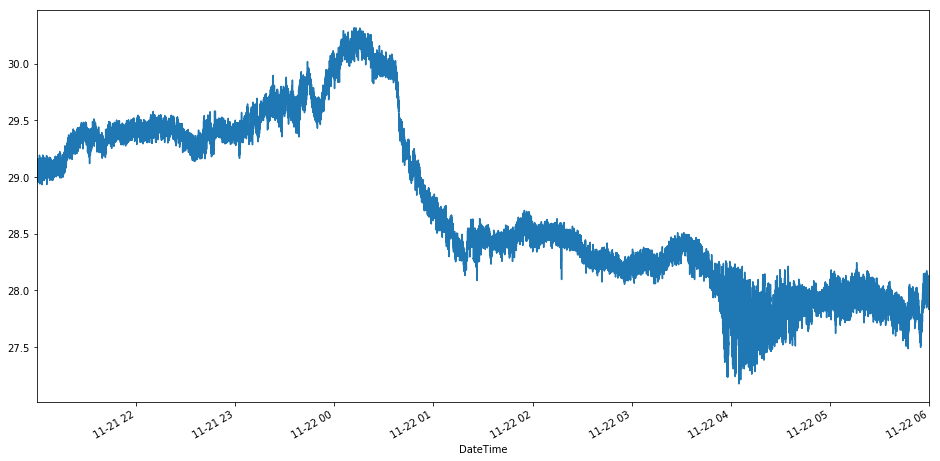

In [16]:
kt.SST_nocal.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].plot(figsize=(16,8))

Tought to look at a timeseries of this length with the full sub-second resolution. Let's apply a centered rolling mean to tease out the longer-term trends:

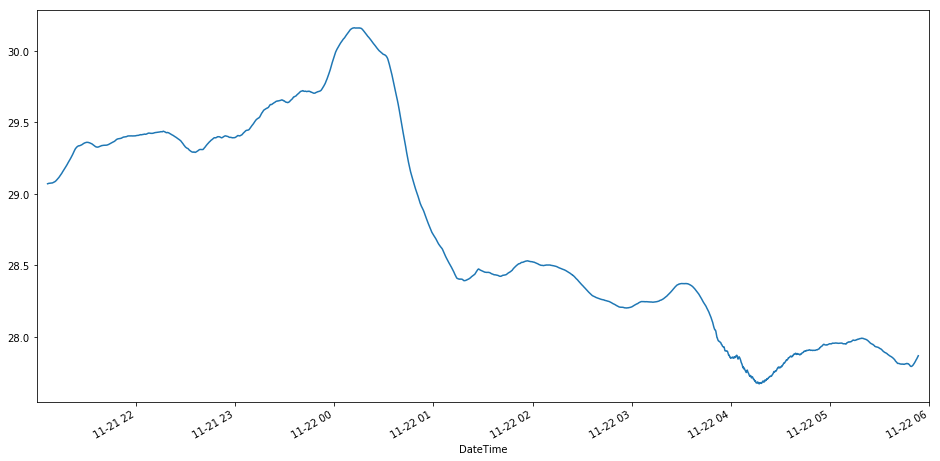

In [17]:
kt.SST_nocal.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].rolling(1000,center=True).mean().plot(figsize=(16,8))

Timeline of events _At SPIP's location_: 
1. Winds pick up around 00:30, destroying the DWL and likely leading to the sudden decrease in SST measured by the KT-15s. 
2. Light rain begins around 01:15, and SPIP observes a cold surface layer (likely due to the heat flux associated with the wind increase). 
3. Then from 03:45-04:00, the rain rate increases greatly and a cold freshwater lens develops in the upper ~1.5m. We see that reflected in the KT15 data as well, a significant drop in the same time period. 
4. Unfortunately SPIP was pulled shortly after 4:00, but the KT15 data does suggest that the rain event did not last much longer than that. Perhaps we could use ship met data to corroborate the story of the storm passing. The Mitie makes observations again from 04:27-04:47, so that could also give us insight into the tail end of the event. 

**note that the ship was maneuvering throughout this entire event, we will have to be very careful about that**

**Do the same treatment as Dynamo for Falkor16+19 rain events (piece together rain onset times from public cat data)**

Read BAMS article (Chen & Moum) about DYNAMO and Laxague+Zappa article about rain event from 2016.

Should also refer to some SPURS work - Zappa to find

Katsaros 198X paper shows exactly how to generate the sky correction coefficients. Zappa 1998 Appendix also talks about this.

Add 9-11um instrument to toolbox (once Zappa finds igor function)

### Literature Review: 
- Chen & Moum BAMS dynamo summary paper
- Simon P. de Szoeke Dynamo Paper (https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-14-00477.1)
- Big Dynamo paper (https://journals.ametsoc.org/doi/full/10.1175/JAS-D-13-0348.1)
- Laxague+Zappa article about Falkor rain event from 2016
- SPURS papers (https://www.jstor.org/stable/26651184?seq=1#metadata_info_tab_contents)


## Appendix 1: KT-15 Processing

We will follow the same importing steps multiple times, once for each experiment. Start by importing all the python packages we'll need, along with the custom functions contained in the module 'KT15_Toolbox.py'.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import glob
from matplotlib import pyplot as plt
%matplotlib inline
#plt.style.use("classic")

from KT15_Toolbox import KT15_importraw, KT15_labcalibration, KT15_calibrate_skycorrect82

### - Falkor 2019 -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [4]:
#Falkor 2019: Takes ~7 minutes to run. 
KT15_importraw(data_folder = '..\Data\Level_0\Falkor19\KT15',
               output_path = '..\Data\Level_1\Falkor19\KT15', 
               sea_serial = 7417,
               sky_serial = 7409, 
               experiment = 'Falkor19')

Next we'll import calibration data acquired in the Lab while looking at a blackbody, and extract a linear fit from the data that allows us to calibrate our field measurements and increase their accuracy.

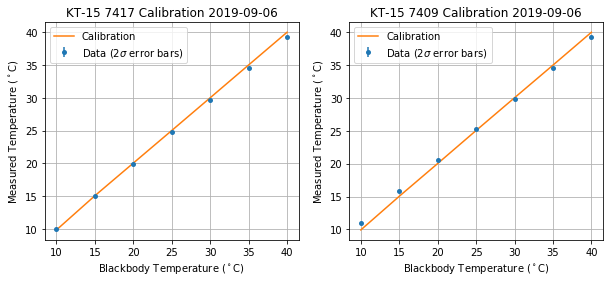

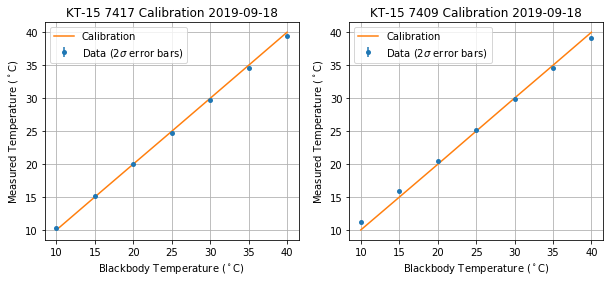

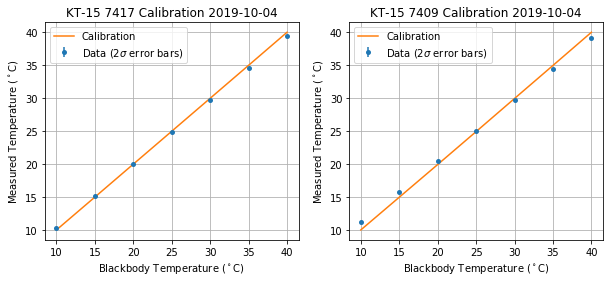

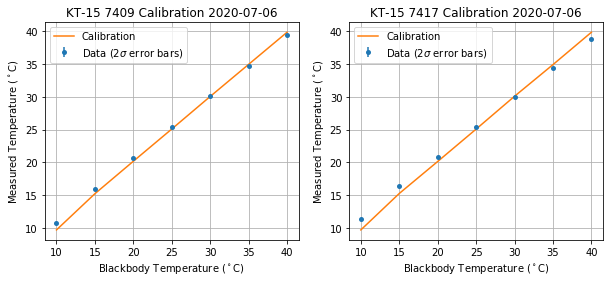

In [3]:
for cal_folder in glob.glob('../Data/Level_0/Falkor19/KT15_LabCalibrations/*'):  
    KT15_labcalibration(data_folder = cal_folder,
                        output_path = '../Data/Level_1/Falkor19/KT15_LabCalibrations', 
                        caltemps = [10,15,20,25,30,35,40])

We are ready to apply the lab calibrations and sky-correct the data:

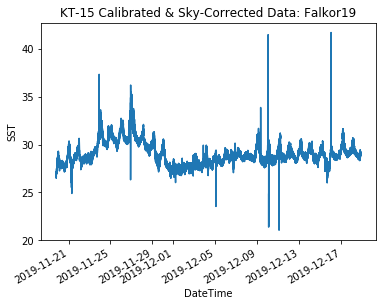

In [12]:
%autoreload
from KT15_Toolbox import KT15_calibrate_skycorrect82
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Falkor19/KT15/Falkor19_KT15_7417_7409.cdf',
                            output_path = '../Data/Level_3/Falkor19/KT15/',
                            cal_path = '../Data/Level_1/Falkor19/KT15_LabCalibrations/')

The KT-15 SST is now an L3 product, ready for use in science analysis in the body of the paper.

### - Falkor 2016 -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [ ]:
#Falkor 2016: Takes ~7 minutes to run. Note the sea and sky instruments are opposite from Falkor19
KT15_importraw(data_folder = '../Data/Level_0/Falkor16/KT15/',
               output_path = '../Data/Level_1/Falkor16/KT15/', 
               sea_serial = 7409,
               sky_serial = 7417, 
               experiment = 'Falkor16')

Next we'll import calibration data acquired in the Lab while looking at a blackbody, and extract a linear fit from the data that allows us to calibrate our field measurements and increase their accuracy.

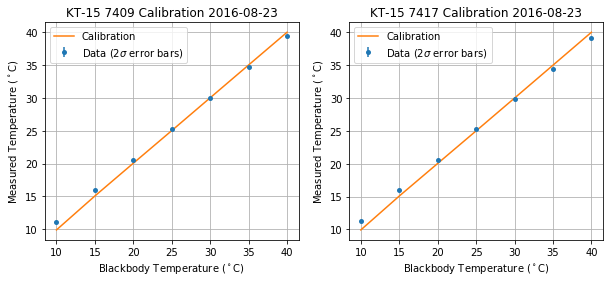

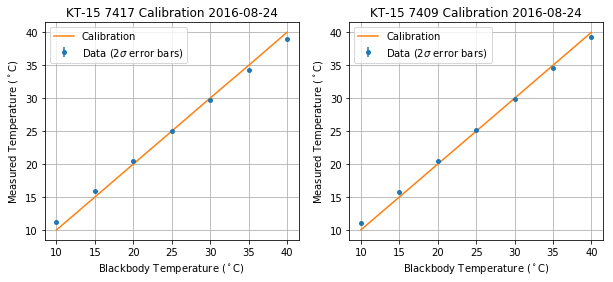

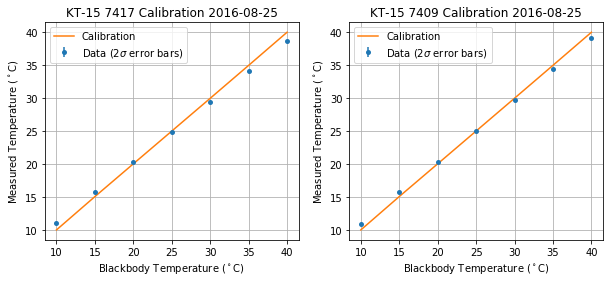

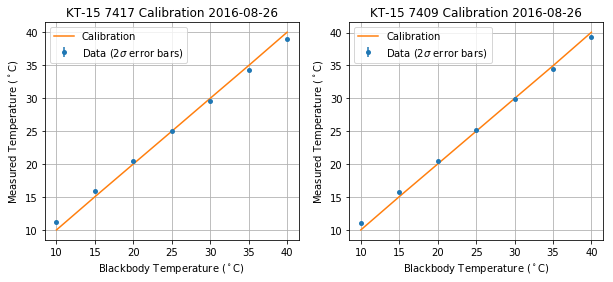

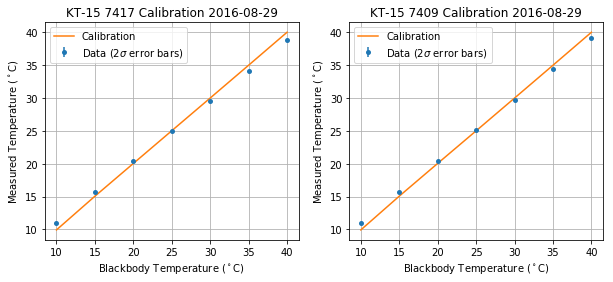

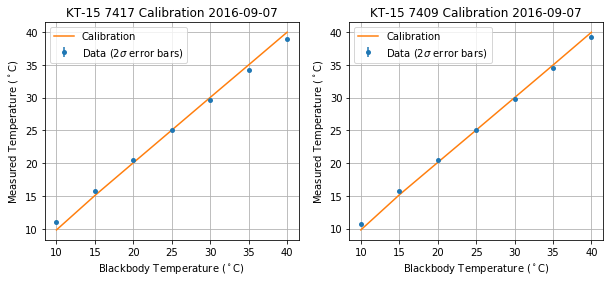

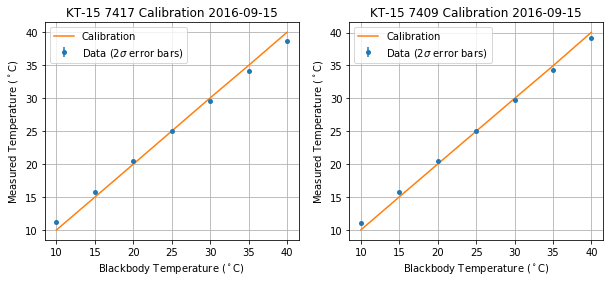

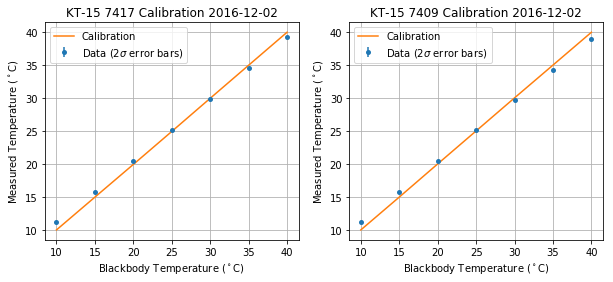

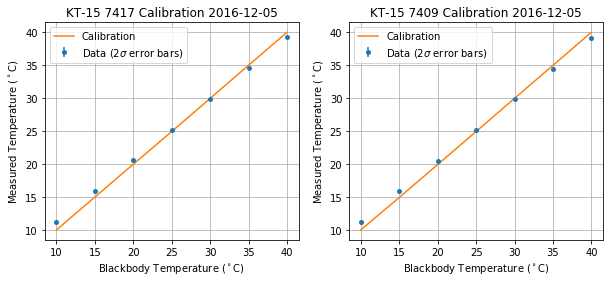

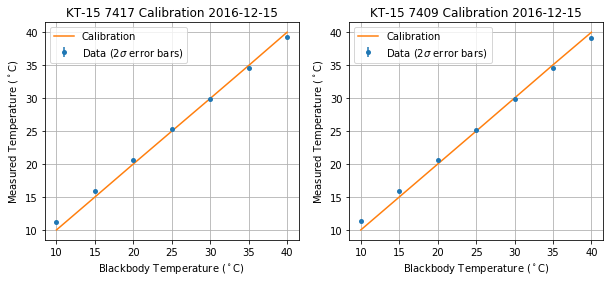

In [3]:
for cal_folder in glob.glob('../Data/Level_0/Falkor16/KT15_LabCalibrations/*'):  
    KT15_labcalibration(data_folder = cal_folder,
                        output_path = '../Data/Level_1/Falkor16/KT15_LabCalibrations', 
                        caltemps = [10,15,20,25,30,35,40])

We are ready to apply the lab calibrations and sky-correct the data:

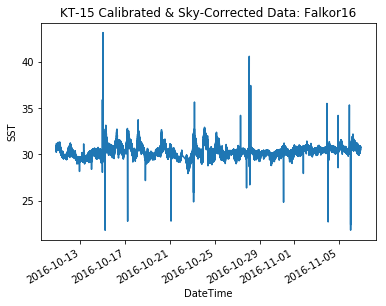

In [4]:
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Falkor16/KT15/Falkor16_KT15_7409_7417.cdf',
                            output_path = '../Data/Level_3/Falkor16/KT15/',
                            cal_path = '../Data/Level_1/Falkor16/KT15_LabCalibrations/')

The KT-15 SST is now an L3 product, ready for use in science analysis in the body of the paper.

### - Dynamo -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [ ]:
#Dynamo 2011: Takes ~30 minutes to run.
KT15_importraw(data_folder = '../Data/Level_0/Dynamo/KT15/',
               output_path = '../Data/Level_1/Dynamo/KT15/', 
               sea_serial = 7409,
               sky_serial = 7417, 
               experiment = 'Dynamo')

The KT-15s were calibrated by Deb using constants "calculated by Eric circa 2007" and "in use until at least June 2013". It is critical to note that her code treats "a" as the y-intercept and "b" as the slope, which is counter-intuitive to me so I need to keep that straight. These are the coefficients:

- Upa = 2.6117;       % +/- 0.0344	(yint) % KT7417
- Upb = 0.90621;      % +/- 0.00143 (slope)
- Downa = 1.4897;     % +/- 0.0281	(yint) %KT7409
- Downb = 0.94989;    % +/- 0.00117 (slope)

It appears there was also a calibration done in 2014, with these coefficients:

- Upb = 0.9509; (slope)      
- Upa = 1.28615; (yint)      
- Downb = 0.9726; (slope)    
- Downa = 0.65781; (yint)

Let's compare these coefficients to the ones on the two Falkor experiments:

In [8]:
xr.open_dataset('../Data/Level_3/Falkor16/KT15/Falkor16_KT15_CalibratedSST.cdf').attrs

OrderedDict([('experiment', 'Falkor16'),
             ('sea_serial', 7409),
             ('sky_serial', 7417),
             ('sea_slope', 0.9356645728890147),
             ('sea_yint', 1.7417109487690503),
             ('sky_slope', 0.9270068573636857),
             ('sky_yint', 1.9150189288935866)])

In [9]:
xr.open_dataset('../Data/Level_3/Falkor19/KT15/Falkor19_KT15_CalibratedSST.cdf').attrs

OrderedDict([('experiment', 'Falkor19'),
             ('sea_serial', 7417),
             ('sky_serial', 7409),
             ('sea_slope', 0.9727612699942666),
             ('sea_yint', 0.4628266465754239),
             ('sky_slope', 0.9338967855693827),
             ('sky_yint', 1.8237596338977193)])

Generally, all the slopes are very close to 1, and the y-intercepts vary between 0.5-2. All seems quite reasonable. Still, given the inconsistencies in Deb's code (such as a section in which she was trying switching the slopes and yintercepts for reasons I cannot fathom), I'd like to get a hold of the actual raw calibration data. But I cannot find it in any obvious place on the servers, so I may have no choice but to trust these coefficients from Deb's code...

For now, because they seem reasonable enough, I'll just manually make cal files for both the 2007 and 2014 coefficients:

In [6]:
output_path = '../Data/Level_1/Dynamo/KT15_LabCalibrations/'

cal_7409_2007 = xr.Dataset(attrs={'serial_number':7409,
                                  'calibration_date':'2007',
                                  'slope':0.94989,
                                  'yint': 1.4897})
cal_7409_2007.to_netcdf(output_path+'/KT15_LabCalibration_7409_2007-00-00.cdf')

cal_7409_2014 = xr.Dataset(attrs={'serial_number':7409,
                                  'calibration_date':'2014',
                                  'slope':0.9726,
                                  'yint': 0.65781})
cal_7409_2014.to_netcdf(output_path+'/KT15_LabCalibration_7409_2014-00-00.cdf')

cal_7417_2007 = xr.Dataset(attrs={'serial_number':7417,
                                  'calibration_date':'2007',
                                  'slope':0.90621,
                                  'yint': 2.6117})
cal_7417_2007.to_netcdf(output_path+'/KT15_LabCalibration_7417_2007-00-00.cdf')

cal_7417_2014 = xr.Dataset(attrs={'serial_number':7417,
                                  'calibration_date':'2014',
                                  'slope':0.9509,
                                  'yint': 1.28615})
cal_7417_2014.to_netcdf(output_path+'/KT15_LabCalibration_7417_2014-00-00.cdf')

We are ready to apply the lab calibrations and sky-correct the data:

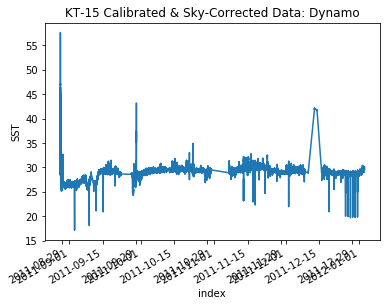

In [11]:
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Dynamo/KT15/Dynamo_KT15_7409_7417.cdf',
                            output_path = '../Data/Level_3/Dynamo/KT15/',
                            cal_path = '../Data/Level_1/Dynamo/KT15_LabCalibrations/')

The KT-15 SST is now an L3 product, ready for use in science analysis in the body of the paper.

## Appendix 2: Rain Data Processing

### - Falkor 2016 -

Rain data available to us from Falkor 2016 come from the tipping bucket sensor on the catamaran. We'll import that and take a look at it here.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import glob
import tqdm
import time
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\cwitt\Anaconda3\lib\site-packages\distributed\utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] A socket operation was attempted to an unreachable network
  RuntimeWarning,


In [2]:
#make the relevant variables (ie rain rate) be formatted identically to Dynamo dataset so that we can run the same function on them 
cat = pd.read_csv('../Data/Level_1/Falkor16/Catamaran/Wurl-etal_2017.tab',skiprows=82,delimiter='\t',index_col=2,parse_dates=True,
                   names=['Event','Method','Lon','Lat','Depth_SML','Depth_Bulk',
                          'LocalTime','fDOM_Volts_SML','fDOM_SML','fDOM_Volts_Bulk','fDOM_Bulk',
                          'fDOM_EF','Fo','Fm','No','Fv','Ft','Chl_a','Chl_QF','Sal_SML','Sal_Bulk','Sal_delta',
                          'pH_SML','pH_Bulk','pH_delta','Temp_SML','Temp_Bulk','Temp_delta',
                          'TempHP_2cm','TempHP_15cm','TempHP_delta','AirTemp','RH','DewPoint',
                          'WindSpeed','WindDir','Pres','HeatIndex','THWIndex','THSWIndex','Precip','P','SW','SolarE','UVI',
                          'Erythem','HDD','CDD','SAS_SML','SAS_SML_std','SAS_Bulk','SAS_Bulk_std','SAS_EF'])

#there are 6 entries per minute and only one of them contains useful data - drop all the lines that have NaN as the precip value
cat = cat[~np.isnan(cat['P'])]
#convert to xarray and fill out metadata
cat_xr = cat.to_xarray()

cat_xr.attrs['experiment'] = 'Falkor2016'

cat_xr.Lon.attrs['long_name'] = 'Longitude'
cat_xr.Lon.attrs['units'] = 'deg'

cat_xr.Lat.attrs['long_name'] = 'Latitude'
cat_xr.Lat.attrs['units'] = 'deg'

cat_xr.Depth_SML.attrs['long_name'] = 'Water Depth of SML Measurements'
cat_xr.Depth_SML.attrs['units'] = 'm'

cat_xr.Depth_Bulk.attrs['long_name'] = 'Water Depth of Bulk Measurements'
cat_xr.Depth_Bulk.attrs['units'] = 'm'

cat_xr.fDOM_Volts_SML.attrs['long_name'] = 'Raw Voltage Output of SML fDOM Measurements'
cat_xr.fDOM_Volts_SML.attrs['units'] = 'mV'

cat_xr.fDOM_SML.attrs['long_name'] = 'SML Fluorescent Dissolved Organic Matter'
cat_xr.fDOM_SML.attrs['units'] = 'µg/l'

cat_xr.fDOM_Volts_Bulk.attrs['long_name'] = 'Raw Voltage Output of SML fDOM Measurements'
cat_xr.fDOM_Volts_Bulk.attrs['units'] = 'mV'

cat_xr.fDOM_Bulk.attrs['long_name'] = 'Bulk Fluorescent Dissolved Organic Matter'
cat_xr.fDOM_Bulk.attrs['units'] = 'µg/l'

cat_xr.fDOM_EF.attrs['long_name'] = 'Fluorescent Dissolved Organic Matter Enrichment Factor'

cat_xr.Fo.attrs['long_name'] = 'Minimum Fluorescence'

cat_xr.Fm.attrs['long_name'] = 'Maximum Fluorescence'

cat_xr.No.attrs['long_name'] = 'Number blank'

cat_xr.Fv.attrs['long_name'] = 'Fluorescence, variable'

cat_xr.Ft.attrs['long_name'] = 'Fluorescence, yield at any given time'

cat_xr.Chl_a.attrs['long_name'] = 'Chlorophyll a'
cat_xr.Chl_a.attrs['units'] = 'µg/l'

cat_xr.Chl_QF.attrs['long_name'] = 'Chlorophyll Quality Flag (< means Fm lower than calibration curve)'

cat_xr.Sal_SML.attrs['long_name'] = 'SML Salinity'
cat_xr.Sal_SML.attrs['units'] = 'psu'

cat_xr.Sal_Bulk.attrs['long_name'] = 'Bulk Salinity'
cat_xr.Sal_Bulk.attrs['units'] = 'psu'

cat_xr.Sal_delta.attrs['long_name'] = 'Salinity Difference between SML and Bulk'
cat_xr.Sal_delta.attrs['units'] = 'psu'

cat_xr.pH_SML.attrs['long_name'] = 'SML pH'

cat_xr.pH_Bulk.attrs['long_name'] = 'Bulk pH'

cat_xr.pH_delta.attrs['long_name'] = 'pH Difference between SML and Bulk'

cat_xr.Temp_SML.attrs['long_name'] = 'SML Temperature'
cat_xr.Temp_SML.attrs['units'] = '°C'

cat_xr.Temp_Bulk.attrs['long_name'] = 'Bulk Temperature'
cat_xr.Temp_Bulk.attrs['units'] = '°C'

cat_xr.Temp_delta.attrs['long_name'] = 'Temperature Difference between SML and Bulk'
cat_xr.Temp_delta.attrs['units'] = '°C'

cat_xr.TempHP_2cm.attrs['long_name'] = 'High-Precision Temperature at 2cm Depth'
cat_xr.TempHP_2cm.attrs['units'] = '°C'

cat_xr.TempHP_15cm.attrs['long_name'] = 'High-Precision Temperature at 15cm Depth'
cat_xr.TempHP_15cm.attrs['units'] = '°C'

cat_xr.TempHP_delta.attrs['long_name'] = 'Temperature Difference between 2cm and 15cm Depth'
cat_xr.TempHP_delta.attrs['units'] = '°C'

cat_xr.AirTemp.attrs['long_name'] = 'Air Temperature'
cat_xr.AirTemp.attrs['units'] = '°C'

cat_xr.RH.attrs['long_name'] = 'Relative Humidity'
cat_xr.RH.attrs['units'] = '%'

cat_xr.DewPoint.attrs['long_name'] = 'Dew/Frost Point'
cat_xr.DewPoint.attrs['units'] = '°C'

cat_xr.WindSpeed.attrs['long_name'] = 'Wind Speed'
cat_xr.WindSpeed.attrs['units'] = 'm/s'

cat_xr.WindDir.attrs['long_name'] = 'Wind Direction Description'

cat_xr.Pres.attrs['long_name'] = 'Air Pressure'
cat_xr.Pres.attrs['units'] = 'bar'

cat_xr.HeatIndex.attrs['units'] = '°C'
cat_xr.THWIndex.attrs['units'] = '°C'
cat_xr.THSWIndex.attrs['units'] = '°C'

cat_xr.Precip.attrs['long_name'] = 'Total Rainfall'
cat_xr.Precip.attrs['units'] = 'mm'

cat_xr.P.attrs['long_name'] = 'Rain Rate'
cat_xr.P.attrs['units'] = 'mm/hr'

cat_xr.SW.attrs['long_name'] = 'Downwelling SW Radiation'
cat_xr.SW.attrs['units'] = 'W/m^2'

cat_xr.SolarE.attrs['long_name'] = 'Solar Energy'
cat_xr.SolarE.attrs['units'] = 'W'

cat_xr.UVI.attrs['long_name'] = 'Ultraviolet Index'

cat_xr.Erythem.attrs['long_name'] = 'Erythemal dose, minimal'
cat_xr.Erythem.attrs['units'] = 'MED'

cat_xr.HDD.attrs['long_name'] = 'Heat degree-day'

cat_xr.CDD.attrs['long_name'] = 'Cool degree-day'

cat_xr.SAS_SML.attrs['long_name'] = 'Surface Active Substances (SML)'
cat_xr.SAS_SML.attrs['units'] = 'mg/L'

cat_xr.SAS_SML_std.attrs['long_name'] = 'Surface Active Substances (SML) Standard Deviation'
cat_xr.SAS_SML_std.attrs['units'] = 'mg/L'

cat_xr.SAS_Bulk.attrs['long_name'] = 'Surface Active Substances (Bulk)'
cat_xr.SAS_Bulk.attrs['units'] = 'mg/L'

cat_xr.SAS_Bulk_std.attrs['long_name'] = 'Surface Active Substances (Bulk) Standard Deviation'
cat_xr.SAS_Bulk_std.attrs['units'] = 'mg/L'

cat_xr.SAS_EF.attrs['long_name'] = 'Surface Active Substances Enrichment Factor'

cat_xr

<xarray.Dataset>
Dimensions:          (index: 5894)
Coordinates:
  * index            (index) datetime64[ns] 2016-10-11T23:34:00 ... 2016-11-06T06:59:00
Data variables:
    Event            (index) object 'FK161010_1' 'FK161010_1' ... 'FK161010_17'
    Method           (index) object 'Cat' 'Cat' 'Cat' ... 'Cat' 'Cat' 'Cat'
    Lon              (index) float64 128.7 128.7 128.7 ... 144.7 144.7 144.7
    Lat              (index) float64 -14.49 -14.49 -14.49 ... 3.631 3.631 3.631
    Depth_SML        (index) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Depth_Bulk       (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    LocalTime        (index) object '09:04:06' '09:05:06' ... '16:59:00'
    fDOM_Volts_SML   (index) float64 0.09 0.09 0.09 0.1 0.12 ... nan nan nan nan
    fDOM_SML         (index) float64 3.6 3.6 3.6 4.0 4.8 ... nan nan nan nan nan
    fDOM_Volts_Bulk  (index) float64 0.07 0.07 0.06 0.06 ... nan nan nan nan
    fDOM_Bulk        (index) float64 2.8 2.8

In [3]:
#save as L3 data product
cat_xr.to_netcdf('../Data/Level_3/Falkor16/Catamaran/catamaran_fk16_alldata.cdf')

Catamaran Data from Falkor 2016 is now a L3 data product, ready for use in science analysis

### - Falkor 2019 -

Rain data available to us from Falkor 2019 come from the tipping bucket sensor on the catamaran. We'll import that and take a look at it here.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import glob
import tqdm
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [48]:
files = glob.glob('../Data/Level_1/Falkor19/Catamaran/SeaSurface_*.csv')
data_list = []

for file in files:
    data = pd.read_csv(file,skiprows=8,index_col=0,parse_dates=True)
    data_list.append(data)

cat19 = pd.concat(data_list)

#want to rename all the variables to match with 2016 data
cat19.rename(columns={'Cool_DD':'CDD',
                      'Dew_point_C':'DewPoint', 
                      'EF':'fDOM_EF', 
                      'FDOM_Bulk':'fDOM_Bulk', 
                      'FDOM_SML':'fDOM_SML', 
                      'Heat_DD':'HDD', 
                      'Heat_Index_C':'HeatIndex',
                      'Latitude_degrees_north':'Lat',
                      'Longitude_degrees_east':'Lon',
                      'Pressure_bar':'Pres', 
                      'Rain_mm':'Precip', 
                      'Rain_rate_mmhr':'P',
                      'Salinity_Bulk':'Sal_Bulk', 
                      'Salinity_SML':'Sal_SML', 
                      'Solar_Energy_W':'SolarE', 
                      'Solar_rad_Wm2':'SW', 
                      'THSW_Index_C':'THSWIndex', 
                      'THW_Index_C':'THWIndex', 
                      'Temp_Air_C':'AirTemp', 
                      'UV_index':'UVI', 
                      'Wind_dir':'WindDir', 
                      'Windspeed_ms':'WindSpeed', 
                      'delta_Sal':'Sal_delta', 
                      'delta_pH':'ph_delta', 
                      }, inplace=True)


#there are 6 entries per minute and only one of them contains useful data - drop all the lines that have NaN as the precip value
cat19 = cat19[~np.isnan(cat19['P'])]


cat19.index.rename('index',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


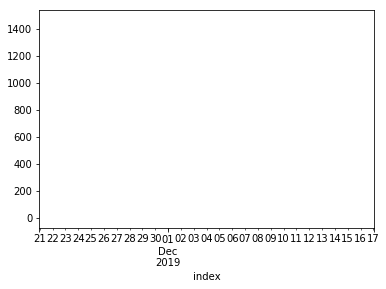

In [65]:
cat19.P.resample('S').apply(np.nanmedian).plot()

In [3]:
#convert to xarray and fill out metadata
cat_xr = cat19.to_xarray()

cat_xr.attrs['experiment'] = 'Falkor2019'

cat_xr.Lon.attrs['long_name'] = 'Longitude'
cat_xr.Lon.attrs['units'] = 'deg'

cat_xr.Lat.attrs['long_name'] = 'Latitude'
cat_xr.Lat.attrs['units'] = 'deg'

cat_xr.fDOM_SML.attrs['long_name'] = 'SML Fluorescent Dissolved Organic Matter'
cat_xr.fDOM_SML.attrs['units'] = 'µg/l'

cat_xr.fDOM_Bulk.attrs['long_name'] = 'Bulk Fluorescent Dissolved Organic Matter'
cat_xr.fDOM_Bulk.attrs['units'] = 'µg/l'

cat_xr.fDOM_EF.attrs['long_name'] = 'Fluorescent Dissolved Organic Matter Enrichment Factor'

cat_xr.Fo.attrs['long_name'] = 'Minimum Fluorescence'

cat_xr.Fm.attrs['long_name'] = 'Maximum Fluorescence'

cat_xr.Fv.attrs['long_name'] = 'Fluorescence, variable'

cat_xr.Sal_SML.attrs['long_name'] = 'SML Salinity'
cat_xr.Sal_SML.attrs['units'] = 'psu'

cat_xr.Sal_Bulk.attrs['long_name'] = 'Bulk Salinity'
cat_xr.Sal_Bulk.attrs['units'] = 'psu'

cat_xr.Sal_delta.attrs['long_name'] = 'Salinity Difference between SML and Bulk'
cat_xr.Sal_delta.attrs['units'] = 'psu'

cat_xr.pH_SML.attrs['long_name'] = 'SML pH'

cat_xr.pH_Bulk.attrs['long_name'] = 'Bulk pH'

cat_xr.AirTemp.attrs['long_name'] = 'Air Temperature'
cat_xr.AirTemp.attrs['units'] = '°C'

cat_xr.RH.attrs['long_name'] = 'Relative Humidity'
cat_xr.RH.attrs['units'] = '%'

cat_xr.DewPoint.attrs['long_name'] = 'Dew/Frost Point'
cat_xr.DewPoint.attrs['units'] = '°C'

cat_xr.WindSpeed.attrs['long_name'] = 'Wind Speed'
cat_xr.WindSpeed.attrs['units'] = 'm/s'

cat_xr.WindDir.attrs['long_name'] = 'Wind Direction Description'

cat_xr.Pres.attrs['long_name'] = 'Air Pressure'
cat_xr.Pres.attrs['units'] = 'bar'

cat_xr.HeatIndex.attrs['units'] = '°C'
cat_xr.THWIndex.attrs['units'] = '°C'
cat_xr.THSWIndex.attrs['units'] = '°C'

cat_xr.Precip.attrs['long_name'] = 'Total Rainfall'
cat_xr.Precip.attrs['units'] = 'mm'

cat_xr.P.attrs['long_name'] = 'Rain Rate'
cat_xr.P.attrs['units'] = 'mm/hr'

cat_xr.SW.attrs['long_name'] = 'Downwelling SW Radiation'
cat_xr.SW.attrs['units'] = 'W/m^2'

cat_xr.SolarE.attrs['long_name'] = 'Solar Energy'
cat_xr.SolarE.attrs['units'] = 'W'

cat_xr.UVI.attrs['long_name'] = 'Ultraviolet Index'

cat_xr.HDD.attrs['long_name'] = 'Heat degree-day'

cat_xr.CDD.attrs['long_name'] = 'Cool degree-day'

cat_xr

<xarray.Dataset>
Dimensions:                 (index: 10965)
Coordinates:
  * index                   (index) datetime64[ns] 2019-11-20T23:25:00 ... 2019-12-17T01:40:00
Data variables:
    Blank                   (index) object nan nan nan nan ... 46.0 46.0 46.0
    Celsius                 (index) float64 nan nan nan nan ... nan nan nan nan
    Cond_Bulk               (index) float64 nan nan nan ... 4.36e+04 4.36e+04
    Cond_SML                (index) float64 4.66e+04 4.66e+04 ... 4.7e+04
    CDD                     (index) float64 0.007 0.007 0.007 ... 24.0 23.0 23.0
    DP                      (index) float64 nan nan nan nan ... nan nan nan nan
    DewPoint                (index) float64 24.8 24.8 24.8 ... 25.8 25.8 25.8
    fDOM_EF                 (index) float64 nan nan nan ... 6.554e+04 6.554e+04
    fDOM_Bulk               (index) float64 nan nan nan nan ... 0.4 0.4 0.0 0.0
    fDOM_SML                (index) float64 nan nan nan nan ... -2.8 -2.4 -2.4
    Fahrenheit              

In [4]:
cat_xr_drop = cat_xr.drop(['Blank','Fm','Yield'])

In [5]:
#save as L3 data product
cat_xr_drop.to_netcdf('../Data/Level_3/Falkor19/Catamaran/catamaran_fk19_alldata.cdf')

Catamaran Data from Falkor 2016 is now a L3 data product, ready for use in science analysis

### - Dynamo -

The data from R/V Revelle was provided by Jim Edson in a L1 .mat format. Here we'll import it and save the relevant variables into a science-ready netcdf.

From the Readme Edson included with the Revelle data files, these are the variables:

| Variable | Description |
|:-----|:-----|
|Yday |     Decimal yearday (UTC)
|Lat  |     Latitude (deg)
|Lon  |     Longitude (deg)
|SOG  |     Speed over ground (m/s)
|COG  |     Course over ground (deg)
|Heading|   Ship's heading (deg)
|Cspd |     Current speed (m/s)
|Cdir |     Current direction (deg) from
|U10  |     Wind speed (m/s) relative to earth adjusted to 10 m
|Wdir |     Wind direction (deg) from relative to earth
|Ur10 |     Wind speed (m/s) relative to water adjusted to 10 m
|WdirR|     Wind direction (deg) from relative to water
|Pair10|    Pressure (mb) adjusted to 10 m
|RH10  |    Relative humidity(%) adjusted to 10 m
|T10   |    Temperature (C) adjusted to 10 m
|Tsea  |    Near surface sea temperature (C) from Sea snake
|SST   |    Sea surface temperature (C) from Tsea minus cool skin
|Q10  |     Specific humidity (g/Kg) adjusted to 10 m
|Qsea |     Specific humidity (g/Kg) 'near' ocean surface from sea snake
|SSQ  |     Sea surface specific humidity (g/Kg) from Qsea minus cool skin
|stress |   Surface stress (N/m2) measured relative to water
|shf  |     Sensible heat flux (W/m2)
|lhf  |     Latent heat flux (W/m2)
|rhf  |     Sensible heat flux from rain (W/m2)
|Solarup |  Reflected solar (W/m2) estimated from Payne (1972)
|Solardn |  Measured downwelling solar (W/m2)
|IRup    |  Upwelling IR (W/m2) computed from SST 
|IRdn    |  Measured downwelling IR (W/m2)
|E       |  Evaporation rate (mm/hr)
|P  |       Precipitation rate (mm/hr)
|Evap |      Accumulated evaporation for Leg (mm)
|Precip |   Accumulated precipitation for Leg (mm)
|Interped | 1=data interpolated due to poor relative winds (0=no interpolation)
           

In [20]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import glob
import tqdm
import time
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.io import loadmat

In [23]:
#generate list of 1min Revelle .mat data files in the Level-1 Folder (provided by Jim Edson)
data_folder = '../Data/Level_1/Dynamo/Revelle_FluxData/'
files = glob.glob(data_folder + '/*1minute*.mat')

Revelle_dfs = []

#iterate over list of files
for filepath in files: 
    #import file as a dictionary of numpy arrays using the scipy loadmat function
    Revelle_Leg = loadmat(filepath)
    print(filepath)
    #drop the metadata keys from the dictionary so that all the remaining arrays are the same size
    del Revelle_Leg['__header__']
    del Revelle_Leg['__version__']
    del Revelle_Leg['__globals__']

    #initialize pandas dataframe with time as the index
    year = 2011
    date = dt.datetime(year, 1, 1) + pd.to_timedelta(Revelle_Leg['yday'][0]-1,unit='days')
    Revelle_df = pd.DataFrame(index=date)

    #iterate over each key in the dict and add to the pandas dataframe as a new column
    for key in Revelle_Leg:
        Revelle_df[key] = Revelle_Leg[key][0].tolist()
    
    #add the pandas dataframe to a list of dataframes
    Revelle_dfs.append(Revelle_df)

#concatenate all the dataframes in the list into one complete dataframe along the vertical (index) axis
RevelleData = pd.concat(Revelle_dfs, axis=0, sort=True)
RevelleData

../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg1_r2b.mat
../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg2_r2b.mat
../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg3_r2b.mat
../Data/Level_1/Dynamo/Revelle_FluxData\Revelle1minuteLeg4_r2b.mat


COG         E       Evap     Heading  \
2011-09-03 00:00:00.000000000  268.961884  0.228639   0.003811  262.923397   
2011-09-03 00:01:00.000000000  268.963806  0.204495   0.007219  264.991871   
2011-09-03 00:02:00.000000000  271.233568  0.199075   0.010537  268.161121   
2011-09-03 00:03:00.000000000  273.610960  0.212163   0.014073  271.179214   
2011-09-03 00:04:00.000000000  272.700386  0.216773   0.017686  270.285734   
2011-09-03 00:05:00.000000000  271.151632  0.217844   0.021316  267.253357   
2011-09-03 00:06:00.000000000  270.529349  0.217225   0.024937  266.722732   
2011-09-03 00:07:00.000000000  270.705541  0.208690   0.028415  267.997286   
2011-09-03 00:08:00.000000000  270.998061  0.201547   0.031774  268.234582   
2011-09-03 00:09:00.000000000  271.112588  0.194422   0.035015  268.078593   
2011-09-03 00:10:00.000000000  271.489416  0.202359   0.038387  269.175666   
2011-09-03 00:11:00.000000000  272.050328  0.222453   0.042095  269.590767   
2011-09-03 00:12:00.000000000  272.058595  0.221306   0.045783  269.094328   
2011-09-03 00:13:00.000000000  271.243248  0.214661   0.049361  267.544983   
2011-09-03 00:14:00.000000000  270.570228  0.219027   0.053011  266.662729   
2011-09-03 00:15:00.000000000  270.945556  0.224298   0.056750  268.040123   
2011-09-03 00:16:00.000000000  271.404145  0.219563   0.060409  270.118237   
2011-09-03 00:17:00.000000000  271.473965  0.208111   0.063878  270.118275   
2011-09-03 00:18:00.000000000  270.458601  0.204283   0.067282  267.320214   
2011-09-03 00:19:00.000000000  269.385783  0.212795   0.070829  266.461278   
2011-09-03 00:20:00.000000000  270.592526  0.227784   0.074625  267.955512   
2011-09-03 00:21:00.000000000  271.851423  0.236499   0.078567  270.190928   
2011-09-03 00:22:00.000000000  271.582091  0.227652   0.082361  269.754835   
2011-09-03 00:23:00.000000000  271.303626  0.219321   0.086016  267.735006   
2011-09-03 00:24:00.000000000  271.684310  0.216638   0.089627  268.261148   
2011-09-03 00:25:00.000000000  272.084447  0.202990   0.093010  269.438490   
2011-09-03 00:26:00.000000000  271.387944  0.196744   0.096289  268.217755   
2011-09-03 00:27:00.000000000  270.658879  0.213735   0.099852  267.397248   
2011-09-03 00:28:00.000000000  271.187198  0.219584   0.103511  268.592786   
2011-09-03 00:29:00.000000000  271.738219  0.215231   0.107098  269.767128   
...                                   ...       ...        ...         ...   
2011-12-31 23:31:00.000000000   94.018331  0.125408  63.538684  260.230974   
2011-12-31 23:32:00.000000000   94.563619  0.122606  63.540728  260.178942   
2011-12-31 23:33:00.000000000   95.076618  0.120031  63.542728  260.523076   
2011-12-31 23:34:00.000000000   94.802598  0.117427  63.544685  260.858526   
2011-12-31 23:35:00.000000004   95.460056  0.116619  63.546629  260.309199   
2011-12-31 23:36:00.000000000   96.160332  0.116859  63.548576  259.614563   
2011-12-31 23:37:00.000000000   95.343368  0.119627  63.550570  259.412357   
2011-12-31 23:38:00.000000000   94.800741  0.123885  63.552635  260.248661   
2011-12-31 23:39:00.000000000   95.586417  0.121031  63.554652  260.449118   
2011-12-31 23:39:59.999999996   96.503882  0.114920  63.556568  259.790636   
2011-12-31 23:41:00.000000000   96.540649  0.110335  63.558406  260.046632   
2011-12-31 23:42:00.000000000   96.176535  0.119999  63.560406  260.327385   
2011-12-31 23:43:00.000000000   95.954639  0.125727  63.562502  260.273215   
2011-12-31 23:44:00.000000000   96.304193  0.120162  63.564505  260.205738   
2011-12-31 23:45:00.000000000   96.921846  0.117276  63.566459  260.491569   
2011-12-31 23:46:00.000000004   96.782215  0.119366  63.568449  260.952136   
2011-12-31 23:47:00.000000000   95.864402  0.116453  63.570389  260.848630   
2011-12-31 23:48:00.000000000   95.303221  0.108815  63.572203  260.049131   
2011-12-31 23:49:00.000000000   95.351666  0.100192  63.573873  259.809176   
2011-12-31 23:50:00.000000000   95.967059  0.097993  63.5755

In [31]:
#convert to xarray and fill out metadata (which will make plots self-labeling moving forwards)
Revelle_xr = RevelleData.to_xarray()

Revelle_xr.attrs['experiment'] = 'DYNAMO'

Revelle_xr.Lat.attrs['long_name'] = 'Latitude'
Revelle_xr.Lat.attrs['units'] = 'deg'

Revelle_xr.Lon.attrs['long_name'] = 'Longitude'
Revelle_xr.Lon.attrs['units'] = 'deg'

Revelle_xr.SOG.attrs['long_name'] = 'Speed Over Ground'
Revelle_xr.SOG.attrs['units'] = 'm/s'

Revelle_xr.COG.attrs['long_name'] = 'Course Over Ground'
Revelle_xr.COG.attrs['units'] = 'deg'

Revelle_xr.Heading.attrs['long_name'] = 'Ships Heading'
Revelle_xr.Heading.attrs['units'] = 'deg'

Revelle_xr.cspd.attrs['long_name'] = 'Current Speed'
Revelle_xr.cspd.attrs['units'] = 'm/s'

Revelle_xr.cdir.attrs['long_name'] = 'Current Direction (from)'
Revelle_xr.cdir.attrs['units'] = 'deg'

Revelle_xr.U10.attrs['long_name'] = '10m Wind Speed (relative to earth)'
Revelle_xr.U10.attrs['units'] = 'm/s'

Revelle_xr.wdir.attrs['long_name'] = 'Wind Direction (from, relative to earth)'
Revelle_xr.wdir.attrs['units'] = 'deg'

Revelle_xr.Ur10.attrs['long_name'] = '10m Wind Speed (relative to water)'
Revelle_xr.Ur10.attrs['units'] = 'm/s'

Revelle_xr.wdirR.attrs['long_name'] = 'Wind Direction (relative to water)'
Revelle_xr.wdirR.attrs['units'] = 'deg'

Revelle_xr.Pair10.attrs['long_name'] = '10m Air Pressure'
Revelle_xr.Pair10.attrs['units'] = 'mbar'

Revelle_xr.RH10.attrs['long_name'] = '10m Relative Humidity'
Revelle_xr.RH10.attrs['units'] = '%'

Revelle_xr.RH02.attrs['long_name'] = '2m Relative Humidity'
Revelle_xr.RH02.attrs['units'] = '%'

Revelle_xr.T10.attrs['long_name'] = '10m Air Temperature'
Revelle_xr.T10.attrs['units'] = 'C'

Revelle_xr.T02.attrs['long_name'] = '2m Air Temperature'
Revelle_xr.T02.attrs['units'] = 'C'

Revelle_xr.Tsea.attrs['long_name'] = 'Near-surface temperature (sea snake)'
Revelle_xr.Tsea.attrs['units'] = 'C'

Revelle_xr.TseaTSG.attrs['long_name'] = 'Ship intake temperature'
Revelle_xr.TseaTSG.attrs['units'] = 'C'

Revelle_xr.SST.attrs['long_name'] = 'SST calculated from sea snake minus cool skin'
Revelle_xr.SST.attrs['units'] = 'C'

Revelle_xr.Q10.attrs['long_name'] = '10m Specific Humidity'
Revelle_xr.Q10.attrs['units'] = 'g/kg'

Revelle_xr.Q02.attrs['long_name'] = '2m Specific Humidity'
Revelle_xr.Q02.attrs['units'] = 'g/kg'

Revelle_xr.Qsea.attrs['long_name'] = 'Specific Humidity "near" ocean surface (sea snake)'
Revelle_xr.Qsea.attrs['units'] = 'g/kg'

Revelle_xr.SSQ.attrs['long_name'] = 'Sea Surface Specific Humidity from sea snake minus cool skin'
Revelle_xr.SSQ.attrs['units'] = 'g/kg'

Revelle_xr.stress.attrs['long_name'] = 'Surface stress relative to water'
Revelle_xr.stress.attrs['units'] = 'N/m^2'

Revelle_xr.shf.attrs['long_name'] = 'Sensible Heat Flux'
Revelle_xr.shf.attrs['units'] = 'W/m^2'

Revelle_xr.lhf.attrs['long_name'] = 'Latent Heat Flux'
Revelle_xr.lhf.attrs['units'] = 'W/m^2'

Revelle_xr.rhf.attrs['long_name'] = 'Sensible Heat Flux From Rain'
Revelle_xr.rhf.attrs['units'] = 'W/m^2'

Revelle_xr.Solarup.attrs['long_name'] = 'Reflected Solar estimated from Payne (1972)'
Revelle_xr.Solarup.attrs['units'] = 'W/m^2'

Revelle_xr.Solardn.attrs['long_name'] = 'Measured Downwelling Solar'
Revelle_xr.Solardn.attrs['units'] = 'W/m^2'

Revelle_xr.IRup.attrs['long_name'] = 'Upwelling IR computed from SST'
Revelle_xr.IRup.attrs['units'] = 'W/m^2'

Revelle_xr.IRdn.attrs['long_name'] = 'Measured Downwelling IR'
Revelle_xr.IRdn.attrs['units'] = 'W/m^2'

Revelle_xr.E.attrs['long_name'] = 'Evaporation Rate'
Revelle_xr.E.attrs['units'] = 'mm/hr'

Revelle_xr.P.attrs['long_name'] = 'Precipitation Rate'
Revelle_xr.P.attrs['units'] = 'mm/hr'

Revelle_xr.Evap.attrs['long_name'] = 'Accumulated evaporation for cruise leg'
Revelle_xr.Evap.attrs['units'] = 'mm'

Revelle_xr.Precip.attrs['long_name'] = 'Acummulated precipitation for cruise leg'
Revelle_xr.Precip.attrs['units'] = 'mm'

Revelle_xr.interped.attrs['long_name'] = '1=data interpolated due to poor relative winds (0=no interpolation)'
Revelle_xr.interped.attrs['units'] = 'n/a'

Revelle_xr.SalTSG.attrs['long_name'] = 'Salinity at ship intake'
Revelle_xr.SalTSG.attrs['units'] = 'psu'

In [40]:
#save as L3 data product
Revelle_xr.to_netcdf('..\Data\Level_3\Dynamo\Revelle_FluxData\Revelle_All_Legs.cdf')

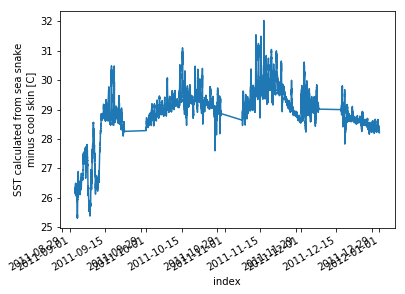

In [38]:
plt.subplots(facecolor='w')
Revelle_xr.SST.plot()

## Function Development